# Lekce 3

## Metoda `apply`

Metoda `apply()` nám umožňuje používat vlastní funkce. Pokud tedy nějakou úpravu dat sám modul `pandas` neumí, případně pokud by bylo jejich použití příliš složité a nepřehledné, můžeme si vytvořit vlastní funkci.

Vlastní funkci vytváříme pomocí klíčového slova `def`. Poté přidáme název funkce a parametry, které příjmá. U `pandas` máme možnost použít funkci dvěma způsoby:

- pracovat s hodnotou v konkrétním sloupci,
- pracovat se všemi hodnotami v řádku.

Vyzkoušíme si použití pro celou tabulku. V tabulce [vysledky.csv](vysledky.csv) máme známky z maturitní zkoušky a naším úkolem je zjistit, zda člověk prospěl s vyznamenáním, prospěl (bez vyznamenání) či neprospěl. Pravidla jsou následující:

- pokud má člověk průměr do 1.5 a nemá horší známku než 2, prospěl s vyznamenáním,
- pokud dostal známku 5, pak neprospěl,
- ve všech ostatních případech prospěl.

Vytvoříme si funkci `evaluate_result()`, která bude mít jako jeden parametr `row` (řádek tabulky). Parametr `row()` je série, tj. můžeme vybírat konkrétní hodnoty (např. známku z vybraného předmětu), dále můžeme využívat agregační funkce jako průměr či maximum.

In [ ]:
import pandas

def evaluate_result(row):
    row = row.iloc[2:]
    if row.mean() <= 1.5 and row.max() <= 2:
        return "Prospěl(a) s vyznamenáním"
    elif row.max() == 5:
        return "Neprospěl(a)"
    else:
        return "Prospěl(a)"

data = pandas.read_csv("vysledky.csv")
data["vysledek"] = data.apply(evaluate_result, axis=1)
data.head()

Nyní si vyzkoušíme, jak funguje výběr jedné hodnoty nebo více hodnot. Uvažujme například, že nyní řešíme přijetí studentů/studentek na vysokou školu s matematickým zaměřením. Jako první zkontrolujeme, zda student zaplatil administrativní poplatek za podání přihlášky. Ve sloupci `Poplatek` vidíme datum (pokud je poplatek zaplacen) nebo prázdnou hodnotu (pokud zaplacen není). Na začátku tedy využijeme funkce `pandas.isnull()`, která vrátí `True`, pokud je pro daný řádek daný sloupec prázdný, a `False`, pokud pro daný řádek ve sloupci nějaká hodnota je. Dále řešíme, zda má být student přijet bez přijímací zkoušky. Škola umožňuje přijetí studentů bez přijímací zkoušky, pokud mají z maturity jedničku z matematiky a současně mají průměr všech známek menší nebo roven 2.

In [ ]:
def evaluate_application(row):
    row = row.iloc[1:]
    if pandas.isnull(row["Poplatek"]):
        return "Vyřazen - nezaplatil"
    elif row["Matematika"] == 1 and row["Český jazyk":"Matematika"].mean() <= 2:
        return "Přijat bez PZ"
    else:
        return "Musí absolvovat PZ"
    
data["prijimaci_zkouska"] = data.apply(evaluate_application, axis=1)
data.head()

### Volání s parametry

Metoda `apply()` umožňuje přidání vlastních hodnot při volání funkce. Pokud bychom například chtěli změnit hranici pro přijetí studenta (studentky) mezi roky, namísto úpravy vnitřku funkce můžeme přidat parametr `hranice_prumer`. Jeho konkrétní hodnotu pak zadáme jako parametr `args`. Protože obecně můžeme mít parametrů více, zapisujeme jejich hodnoty do seznamu.

In [ ]:
def evaluate_application(row, hranice_prumer):
    row = row.iloc[1:]
    if pandas.isnull(row["Poplatek"]):
        return "Vyřazen - nezaplatil"
    elif row["Matematika"] == 1 and row["Český jazyk":"Matematika"].mean() <= hranice_prumer:
        return "Přijat bez PZ"
    else:
        return "Pozvat na PZ"
    
data["prijimaci_zkouska"] = data.apply(evaluate_application, axis=1, args=[1.5])
data.head()

## Použití metody shift

V některých případech se v datech potřebujeme podívat o řádek výše nebo níže, často to může být v souvislosti s datem a časem. Uvažujme například nějaký program, který zapisuje začátek a konec nějaké události. Událost a její typ vždy zapíše jako samostatný řádek. Abychom zjistili délku události, potřebujeme spočítat rozdíl mezi hodnotami data a času ve dvou řádích. K tomu slouží metoda `shift`.

Uvažujme například zařízení, které monitoruje výpadky televizního signálu. Zařízení zapisuje záznamy o začátku a konci výpadku do logovacího souboru.


In [1]:
import pandas as pd

signal_monitoring = pd.read_csv("signal_monitoring.csv")
signal_monitoring["event_date_time"] = pd.to_datetime(signal_monitoring["event_date_time"])
signal_monitoring.head()

,event_type,event_date_time
0,signal lost,2021-02-03 00:40:08
1,signal restored,2021-02-03 01:14:11
2,signal lost,2021-02-05 19:14:19
3,signal restored,2021-02-05 19:46:29
4,signal lost,2021-02-06 14:31:34


Nyní použijeme metodu `shift` na sloupec `event_date_time`. Pomocí metody pak přidáme k tabulce **nový sloupec**. Nejdůležitějším parametrem metody je parametr `periods`, který může mít kladnou nebo zápornou hodnotu.

- Kladná hodnota parametru `periods` znamená, že hodnoty budou posunuty směrem dolů.
- Záporná hodnota parametru `periods` znamená, že hodnoty budou posunuty směrem nahoru.

Pro náš případ bude ideální, pokud posuneme hodnoty sloupce `event_date_time` o jeden řádek směrem nahoru. Tím zajistíme, že pokud má sloupec `event_type` hodnotu `signal lost`, uvidíme v jednom řádku začátek i konec výpadku. Tím padem bude stačit tyto hodnoty od sebe odečíst. Pro `event_type` `signal restored` nebude mít tato hodnota smysl, ale to nevadí, tyto řádky můžeme pomocí dotazu z tabulky odfiltrovat.

In [14]:
signal_monitoring["event_end_date_time"] = signal_monitoring["event_date_time"].shift(periods=-1)
signal_monitoring.head()

,event_type,event_date_time,event_end_date_time
0,signal lost,2021-02-03 00:40:08,2021-02-03 01:14:11
1,signal restored,2021-02-03 01:14:11,2021-02-05 19:14:19
2,signal lost,2021-02-05 19:14:19,2021-02-05 19:46:29
3,signal restored,2021-02-05 19:46:29,2021-02-06 14:31:34
4,signal lost,2021-02-06 14:31:34,2021-02-06 14:48:24


Nyní odebereme přebytečné řádky.

In [15]:
signal_monitoring = signal_monitoring[signal_monitoring["event_type"] == "signal lost"]
signal_monitoring.head()

,event_type,event_date_time,event_end_date_time
0,signal lost,2021-02-03 00:40:08,2021-02-03 01:14:11
2,signal lost,2021-02-05 19:14:19,2021-02-05 19:46:29
4,signal lost,2021-02-06 14:31:34,2021-02-06 14:48:24
6,signal lost,2021-02-08 04:59:20,2021-02-08 05:38:29
8,signal lost,2021-02-09 14:21:25,2021-02-09 14:42:22


Nyní můžeme snadno přidat výpočet délky výpadku signálu.

In [16]:
signal_monitoring["outage_length"] = signal_monitoring["event_end_date_time"] - signal_monitoring["event_date_time"]
signal_monitoring.head()

,event_type,event_date_time,event_end_date_time,outage_length
0,signal lost,2021-02-03 00:40:08,2021-02-03 01:14:11,0 days 00:34:03
2,signal lost,2021-02-05 19:14:19,2021-02-05 19:46:29,0 days 00:32:10
4,signal lost,2021-02-06 14:31:34,2021-02-06 14:48:24,0 days 00:16:50
6,signal lost,2021-02-08 04:59:20,2021-02-08 05:38:29,0 days 00:39:09
8,signal lost,2021-02-09 14:21:25,2021-02-09 14:42:22,0 days 00:20:57


Nyní můžeme například vypočítat celkovou délku výpadků signálu v jednotlivých dnech.

In [17]:
signal_monitoring_grouped = signal_monitoring.groupby(signal_monitoring["event_date_time"].dt.date)["outage_length"].sum()
signal_monitoring_grouped.head()

event_date_time
2021-02-03   0 days 00:34:03
2021-02-05   0 days 00:32:10
2021-02-06   0 days 00:16:50
2021-02-08   0 days 00:39:09
2021-02-09   0 days 00:44:38
Name: outage_length, dtype: timedelta64[ns]

Jako poslední krok si ukážeme, jak prezentovat výsledky našeho výpočtu pomocí grafu. Abychom mohli použít sloupcový graf, musíme převést typ `timedelta` na číselnou hodnotu. To zařídíme pomocí vlastnosti `dt.total_seconds`.

<Axes: xlabel='event_date_time'>

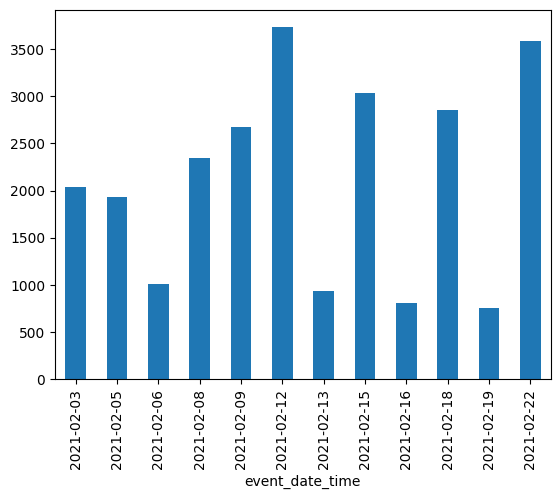

In [18]:
signal_monitoring_grouped_seconds = signal_monitoring_grouped.dt.total_seconds()
signal_monitoring_grouped_seconds.plot(kind="bar")

# Čtení na doma

## Odstraňování duplicit

Duplicitami obecně myslíme opakující se hodnoty v datech. Duplicity mohou vzniknou v důsledku chyby, například:

- program zapíše do databáze nebo do logu stejný údaj dvakrát,
- vzniknou při propojení (`merge`) tabulek.

V některých případech je duplicitní pouze část sloupc. Uvažujme data o registraci uživatelů ze souboru [user_registration.json](user_registration.json). V některých případech uživatel vyplnil registrační formulář do aplikace, ale nepotvrdil e-mailovou adresu (např. mu e-mail padl do spamu) a tak se uživatel po nějaké době zaregistroval znovu.


In [19]:
import pandas
data = pandas.read_json("user_registration.json")
data.head()

,date_time,email,ip_address,age_group,marketing_channel
0,2021-03-01 00:02:13.920,qbichler@kabsi.at,168.155.75.206,30-44,Social network
1,2021-03-01 00:04:27.840,robinkolar@chello.cz,105.132.109.66,18-29,Social network
2,2021-03-01 00:06:41.760,zvesela@chello.cz,105.46.12.139,60+,Newspapers or magazine
3,2021-03-01 00:08:55.680,gmaresova@email.cz,141.22.41.210,60+,Newspapers or magazine
4,2021-03-01 00:11:09.600,qkralova@seznam.cz,196.95.130.168,18-29,Friend's recommendation


Zjistíme nyní počet záznamů v souboru.

In [20]:
data["email"].unique().shape[0]

34398

Pokud budeme chtít seznam unikátních e-mailových adres, můžeme na sérii `email` aplikovat metodu `unique()`.

Pokud budeme chtít odstranit duplicitní registrace z celé tabulky, můžeme využít metodu `drop_duplicates()`. Ta odebere řádky na základě sloupců definovaých jako parametr `subset`. Pokud parametr nevyplníme, jsou použity všechny sloupce. Dále vybíráme, které řádky chceme ponechat. K tomu slouží parametr `last`. Máme tři možnosti:

- ponechat poslední řádek (`last`),
- ponechat první řádek (`first`),
- neponechat ani jeden z duplicitních řádků (`False`).

V našem případě ponecháme poslední řádek. Počet řádků v souboru nyní odpovídá počtu unikátních e-mailových adres, které jsme získali metodou `unique()`.

In [21]:
data_cleaned = data.drop_duplicates(subset="email", keep="last")
data_cleaned.shape

(34398, 5)

### Metoda rank

Metoda `rank` "očísluje" řádky podle zvoleného sloupce. To se hodí třeba v případě, že chceme zjistit a porovnat pořadí záznamů podle nějakého kritéria. Níže máme načtený dataset Indexu ekonomické svobody
(Index of Economic Freedom) z [oficiálního webu](https://www.heritage.org/index/). Index na základě vybraných kritérií vyhodnocuje, nakolik je země ekonomicky svobodná.

In [ ]:
import pandas

ioef = pandas.read_csv("ioef.csv")
ioef.head()

Data zobrazují hodnoty od roku 1995 do roku 2021. Začněme tím, že si určíme pořadí země podle celkvého indexu (sloupec `Overall Score`). K tomu využijeme metodu `rank`. Protože ale potřebujeme určit pořadí vždy pro konkrétní rok, přidáme metodu `groupby` podle sloupce `Index Year`. Tím zajistíme, že číslování pro každý rok začne od 1.

Musíme též nastavit, aby bylo pořadí udělování sestupně, protože čím vyšší je dosažené skóre, tím výše se země na žebříčku ekonomických svobod nachází. To zařídí parametr `ascending`.

Kromě nastavení sloupce má metoda `rank` důležitý parametr `method`. Ta vyřeší případ, že skupina řádků má stejnou hodnotu. Využijeme parametr `dense`, který celé skupině přiřadí hodnotu o 1 vyšší než předchozí skupině. Pro kontrolu si do zvláštní tabulky dáme hodnoty z roku 2023.

In [ ]:
ioef["Rank"] = ioef.groupby(["Index Year"])["Overall Score"].rank(method="min", ascending=False)
ioef_2023 = ioef[ioef["Index Year"] == 2023]
ioef_2023.head()

Podíváme se nyní na pět států s nejnižším pořadím.

In [ ]:
ioef_2023.sort_values(["Rank"]).head()

Nyní porovnáme, jak se vyvíjelo pořadí České republiky. K tomu využijeme metodu `shift()`, abychom do každého řádku přidali pořadí v předcházejícím roce.

In [ ]:
ioef_sorted = ioef.sort_values(["Name", "Index Year"])
ioef_sorted["Rank Previous Year"] = ioef_sorted.groupby(["Name"])["Rank"].shift()
ioef_sorted.head()

Vidíme například, že k největšímu zlepšení došlo v roce 2023 (o 6 příček)

In [ ]:
ioef_sorted["Rank Change"] = ioef_sorted["Rank"] - ioef_sorted["Rank Previous Year"]
ioef_sorted_czech = ioef_sorted[ioef_sorted["Name"] == "Czech Republic"]
ioef_sorted_czech.tail()

# Cvičení

## Závod

Uvažuj časy závodníků za ročníky půlmaratonu 2019 a 2020, které jsou uloženy v souboru [half_marathon.csv](half_marathon.csv). V souboru jsou uloženy pouze časy závodníků, které se zúčastnili obou závodů. V souboru je uloženo jméno závodníka, jeho čas a rok závodu, ke kterému se čas vztahuje. Tvým úkolem je spočítat, o kolik se změnil průměrný čas závodníků a zda se v průměru zlepšili či zhoršili (například protože kvůli lockdownům méně či více trénovali).

Můžeš využít následující postup:

- Seřaď si data (je třeba seřadit data dle jména závodníka i dle roku závodu).
- Převeď sloupec s časem závodníka na typ `datetime`. Můžeš využít stejný postup, jaký jsme si ukázali v lekci. Protože jde pouze o časový údaj, pandas k němu připojí dnešní datum, aby byly ve sloupci datum i čas. Toho si ale nevšímej, u obou sloupců je datum stejný, takže na porovnání údajů to nebude mít vliv.
- Pomocí metody `shift()` si dej na jeden řádek výsledky obou závodů. Je nutné ji použít v kombinaci s metodou `groupby()`, jak je vidět níže. Je třeba nahradit `X` vhodně zvoleným číslem.

```py
df_joined["Cas zavodnika 2020"] = df_joined.groupby("Jmeno")["Cas zavodnika"].shift(X)
```

- Vyřaď z tabulky neúplné řádky pomocí metody `dropna()`.
- Vypočítej rozdíl mezi časy závodníka a převeď ho na sekundy (postup jsme si ukazovali v lekci). Dále spočítej průměrnou změnu. Vyšlo i kladné nebo záporné číslo? A co to znamená.

Řešení příkladu je [zde](reseni.ipynb).

## Nápověda
Po převodu na typ na `datetime` a použití metody `shift()` se dostaneš k výsledku níže. Tento výsledek byl získaný s parametrem -1, tj. hodnoty byly posunuty směrem nahoru. V řádku, kde byl původně čas z roku 2019, uvidíš nyní nově čas z roku 2020, který se posunul nahoru.

In [4]:
import pandas
df = pandas.read_csv("half_marathon_hint_1.csv")
df.head()

,Jmeno,Cas zavodnika,Rok zavodu,Cas zavodnika 2020
0,Adamcová Helena,2023-04-20 01:46:07,2019,NaN
1,Aster Vladimír,2023-04-20 01:53:25,2019,2023-04-20 02:00:19
2,Aster Vladimír,2023-04-20 02:00:19,2020,NaN
3,Asterová Jana,2023-04-20 02:16:59,2019,2023-04-20 02:30:01
4,Asterová Jana,2023-04-20 02:30:01,2020,NaN


Po vypočtení rozdílu by se měl objevit nový sloupec. Znaménko se může lišit, záleží na tom, v jakém pořadí byly sloupce zadány při výpočtu rozdílu.

In [6]:
df = pandas.read_csv("half_marathon_hint_2.csv")
df.head()

,Jmeno,Cas zavodnika,Rok zavodu,Cas zavodnika 2020,Zmena
0,Aster Vladimír,2023-04-20 01:53:25,2019,2023-04-20 02:00:19,0 days 00:06:54
1,Asterová Jana,2023-04-20 02:16:59,2019,2023-04-20 02:30:01,0 days 00:13:02
2,Baborová Anna,2023-04-20 01:58:20,2019,2023-04-20 01:52:25,-1 days +23:54:05
3,Bambas Jan,2023-04-20 02:02:59,2019,2023-04-20 02:35:39,0 days 00:32:40
4,Barochovská Andrea,2023-04-20 03:01:25,2019,2023-04-20 02:50:05,-1 days +23:48:40


A po převodu na sekundy by se měly objevit podobné hodnoty jako níže. Pořád platí, že znaménko se může změnit. Doporučuji se vždy podívat na sloupce s časy v obou letech, kde je lépe vidět, jestli se člověk zlepšil nebo zhoršil. Poté je snazší si uvědomit, jestli kladné číslo znamené zlepšení či zhoršení. Zde znamená zhoršení.

In [7]:
df = pandas.read_csv("half_marathon_hint_3.csv")
df.head()

,Jmeno,Cas zavodnika,Rok zavodu,Cas zavodnika 2020,Zmena
0,Aster Vladimír,2023-04-20 01:53:25,2019,2023-04-20 02:00:19,414.0
1,Asterová Jana,2023-04-20 02:16:59,2019,2023-04-20 02:30:01,782.0
2,Baborová Anna,2023-04-20 01:58:20,2019,2023-04-20 01:52:25,-355.0
3,Bambas Jan,2023-04-20 02:02:59,2019,2023-04-20 02:35:39,1960.0
4,Barochovská Andrea,2023-04-20 03:01:25,2019,2023-04-20 02:50:05,-680.0


### Výsledek

Mělo by ti vyjít, že průměrná změna je asi 584 sekund. To, jestli je číslo kladné nebo záporné záleží na výpočtu rozdílu. Při výpočtu `df["Cas zavodnika 2020"] - df["Cas zavodnika"]` by číslo mělo být kladné a znamená zhoršení (v roce 2020 závodníci běželi déle, čili se zhoršili). Při výpočtu `df["Cas zavodnika"] - df["Cas zavodnika 2020"]` pak vyjde rozdíl záporný (v roce 2019 běželi závodníci kratší čas, proto došlo ke zhoršení).

### Bonus

- Rozděl pomocí funkce `cut()` závodníky na ty, kteří se zlepšili a ty, kteří se zhoršili. Jako hranice můžeš využít "mínus nekonečno" (`float("-inf")`) a "plus nekonečno" (`float("inf")`). Dále pomocí agregace zjisti počty závodníků, kteří se zlepšili a kteří se naopak zhoršili